# BE - Systèmes simples et reconnaissance de parole

L'objectif de ce BE est l'introduction au codage de différentes méthodes de reconnaissance de parole. Pour cela, nous disponsons d'une base de fichiers audio représentants 4 personne prononçant les chiffres de 0 à 9 en anglais. Au cours de ce BE, nous verrons deux méthodes de reconnaissance de parole: un premier modèle utilisant les coefficients LPC et la classification des k plus proches voisins, et un deuxième utilisant les modèles de Markov cachés.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
from librosa.feature import mfcc 
from hmmlearn import hmm 
from scipy.linalg import toeplitz

## Partie 1 : Développement d’un système de reconnaissance de la parole basé sur les coefficients LPC et la classification des k plus proches voisins utilisant la distance élastique. 

La reconnaissance automatique se déroule en 3 grandes étapes: 
 - L'extraction de descripteurs à partir des fichiers audios.
 - L'utilisation d'un modèle acoustique pour passer des descripteurs à des phonèmes. 
 - L'utilisation d'un modèle linguistique pour passer de phonèmes à des mots ou phrases cohérentes. 

Les modèles acoustiques demandent d'abord une étape de paramétrisation afin d'extraire des caractéristiques, pour ensuite passer à l'étape de la décision par comparaison aux classes apprises lors de la phase d'apprentissage.

Pour cette première méthode, nous allons commencer par paramétrer notre signal grâce aux coefficients LPC. Ces coefficients sont calculés par la méthode de Yule-Walker.

In [2]:
def esperance(sound,i):
    return np.mean(sound[0:len(sound)-i]*sound[i:len(sound)])

def compute_R_matrix(sound, N):

    # On calcule la matrice d'autocovariance

    R = np.zeros(N+1)
    for i in range(N+1):
        R[i] = esperance(sound, i)
    R_matrix = toeplitz(R)

    return R_matrix

def compute_LPC_coeff(sound, N, sigma_2):

    # Grâce à la matrice d'autocovariance, on peut déterminer 
    # le vecteur de coefficients LPC pour une plage de notre signal.

    R_matrix = compute_R_matrix(sound, N)
    sigma_2_array = np.zeros(N+1)
    sigma_2_array[0] = sigma_2
    LPC = np.matmul(np.linalg.inv(R_matrix), np.atleast_2d(sigma_2_array).T)
    return LPC/LPC[0]

def compute_LPC(N,sigma_2, time_window, audio, Fe):

    # On calcule enfin les coefficients pour toutes les plages
    
    t_fenetre = int(time_window*Fe)

    sound_length = audio.size/Fe

    # A chaque itération, on décale la plage de la moitié de la largeur d'une plage
    iteration_number = int(sound_length/(time_window/2))

    coeff = np.zeros((N+1,1))
    for i in range(iteration_number):

     start_window_slice = int(i*time_window/2*Fe)
     end_window_slice = start_window_slice + t_fenetre

     if end_window_slice > audio.size:
          break

     extract = audio[start_window_slice:end_window_slice]

    # On applique une fenêtre de hamming sur la plage sélectionnée
     extract = extract * np.hamming(len(extract))
     
     #Puis on calcule les coefficients de cette plage avant de les concaténer aux autres
     temp_coeff = compute_LPC_coeff(extract, N, sigma_2)
     coeff = np.hstack((coeff, temp_coeff))
    
    coeff = coeff[1:, 1:]
    return coeff
        


In [3]:
input_folder='./digit_dataset'
N = 10
sigma_2 = 1
time_window = 20e-3

input_file = input_folder + '/0/0_nicolas_0.wav'
audio, Fe = librosa.load(input_file)
coeff_1 = compute_LPC(N, sigma_2, time_window, audio, Fe)

input_file = input_folder + '/1/1_jackson_47.wav'
audio, Fe = librosa.load(input_file)
coeff_2 = compute_LPC(N, sigma_2, time_window, audio, Fe)

coeff_2[:1]

array([[-0.8677115 , -0.7944788 , -0.90152896, -0.79252956, -0.79274026,
        -0.70897593,  0.61002905, -2.77652881, 10.94804739, -0.11472801,
        -0.57547639,  0.17909975, -4.25063023, -1.85742496, -1.52857951,
        -1.53868511, -1.63676352, -0.95434869, -0.86177507, -0.4146692 ,
         0.15981973,  3.18220241,  1.58014574,  0.13891114, -0.34248977,
        -1.10228945, -0.37825906, -0.07372514,  1.07627361, -0.79957046,
        -0.9704094 , -1.32672521, -1.9149717 , -1.84747159,  6.53851316,
         1.55811287,  0.25478147,  8.33372011, -1.18723782, -0.94284867,
        10.00665739, -0.08384135, -0.60524228, -0.12482586,  1.23849772,
        -7.78907552, -1.64854086, -2.03580841, -1.5705783 ,  0.11215131,
        -1.0607604 , -0.26632684, -2.1595221 , -1.43062905, -2.09919357]])

Viens donc la phase de prise de décision par classification. Cela peut se faire de plusieurs manières, dont la recherche de formes proches, méthode qui est étudiée ici. Pour utiliser cette méthode, il nous faut donc une manière de calculer la proximité entre plusieurs éléments. Pour cela, on utilise la distance élastique, une méthode robuste à plusieurs transformations qui ne changent pas la classe.

In [4]:
def matrix_distance(A:np.ndarray,B:np.ndarray):

    # On calcule d'abord une matrice représentant la distance entre chaque couple de valeurs.
    # Ces couples de valeurs sont un couple de parties de signaux, chacun sur une plage donnée.

    C = np.zeros((A.shape[1], B.shape[1]))

    for i in range(A.shape[1]):
        for j in range(B.shape[1]):
            C[i,j] = np.linalg.norm(A[:,i]-B[:,j])
    
    return C


def elastic_distance(A,B):

    # Une fois cette matrice calculée, on peut calculer la distance élastique.
    # Cette méthode est basée sur un principe de récurrence.
    # Cependant pour limiter la complexité temporelle de la fonction...
    # ...nous calculerons cette distance grâce à une simple boucle

    distance_matrix = matrix_distance(A,B)

    res_matrix = np.zeros((A.shape[1], B.shape[1]))

    # Les poids (coûts) de chaque transformation sont supposés égaux à 1 ici.
    w_h = 1
    w_v = 1
    w_d = 1


    for i in range(A.shape[1]):
        for j in range(B.shape[1]):
            d = distance_matrix[i,j]

            # A chaque étape, le coup de passage aux prochain élément est calculé 
            # grâce aux coûts précédents et à la distance entre deux éléments.

            if i==0 and j==0:
                res_matrix[i,j] = d
            elif i==0:
                res_matrix[i,j] = res_matrix[i,j-1] + w_v*d
            elif j==0:
                res_matrix[i,j] = res_matrix[i-1,j] + w_h*d
            else:
                res_matrix[i,j] = min(res_matrix[i-1,j-1]+w_d*d, res_matrix[i-1,j]+w_h*d, res_matrix[i,j-1]+w_v*d)
    
    return res_matrix

On obtient alors un tableau, une carte montrant le chemin le plus court pour passer d'un signal à l'autre.

Distance : 417.05012064193187


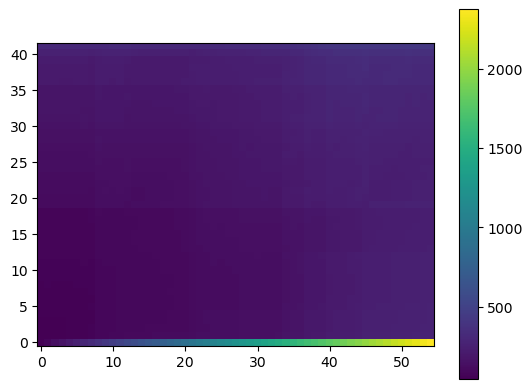

In [5]:
dist = elastic_distance(coeff_1, coeff_2)
print(f"Distance : {dist[-1,-1]}")

plt.imshow(dist)
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

Une fois les différentes parties de l'algorithme définis, on peut passer à l'apprentissage et à la phase de décision

Jason n'est pas chargé, que ce soit pour l'entrainement ou le test. Si on écoute les extraits audio de jason, on remarque que ces derniers sont mal coupés (on peut avoir la fin d'un chiffre et le début d'un autre dans un même fichier), et que souvent ce n'est pas le bon chiffre qui est dit.

In [6]:
data_train = []
data_test = []
labels_train = []
labels_test = []

names = ["jackson", "nicolas","theo"]
number_train = 8
number_test = 2

# Les données sont d'abord séparées en données d'entraînement et de test

for number in range(10):
     for name in names:
          for i in range(number_train):
               input_file = input_folder + f"/{number}/{number}_{name}_{i}.wav"
               try:
                    audio, Fe = librosa.load(input_file)
                    data_train.append(compute_LPC(N, sigma_2, time_window, audio, Fe))
                    labels_train.append(number)
               except Exception as e:
                    print(e)
          for j in range(number_train, number_train+number_test):
               input_file = input_folder + f"/{number}/{number}_{name}_{j}.wav"
               try:

                    audio, Fe = librosa.load(input_file)
                    data_test.append(compute_LPC(N, sigma_2, time_window, audio, Fe))
                    labels_test.append(number)
               except Exception as e:
                    print(e)

labels_train = np.array(labels_train)
labels_test = np.array(labels_test)

In [7]:
def all_distances_matrix_calc(coeffs_train, coeffs_test):

    # Calcule la matrice des distances 2 à 2

    train_length = len(coeffs_train)
    test_length = len(coeffs_test)

    all_distances_matrix=np.zeros((train_length, test_length))

    for i in range(0, train_length):
        for j in range(0, test_length):
            all_distances_matrix[i, j] = elastic_distance(coeffs_train[i], coeffs_test[j])[-1, -1]

    return all_distances_matrix

def knn_predict(dists, labels_train, k):

    # Prédit les classes des données en utilisant la méthode des k plus proches voisins

    N = dists.shape[1]
    labels_predicted = np.zeros(N, dtype = labels_train.dtype)

    indexes = np.argsort(dists, axis=0)[:k, :] # On trie les distances calculées précédemment
    k_nearest_neighbours = labels_train[indexes] # Et on prend les k plus proches

    # Pour chaque point, on extrait la classe la plus présente parmi les k plus proches voisins
    for i in range (0, N):
        values, counts = np.unique(k_nearest_neighbours[:, i], return_counts=True)
        ind = np.argmax(counts)
        labels_predicted[i] = values[ind]
    return labels_predicted
    

def evaluate_knn(coeffs_train, coeffs_test, labels_train, labels_test, k):

    # On évalue les prédiction sur les données de test en calculant l'accuracy

    dist = all_distances_matrix_calc(coeffs_train, coeffs_test)
    predictions = knn_predict(dist, labels_train, k)
    print(predictions)
    correct_prediction = np.count_nonzero(predictions == labels_test)
    print(f"Good predictions: {correct_prediction}")
    print(f"Total predictions: {labels_test.shape[0]}")
    prediction_number = predictions.shape[0]
    return correct_prediction/prediction_number

In [9]:
evaluate_knn(data_train, data_test, np.array(labels_train), np.array(labels_test), 3)

[0 0 1 0 2 0 1 1 1 1 1 1 2 2 1 2 2 1 3 1 2 1 3 3 4 4 2 1 9 4 3 1 6 4 2 2 7
 7 6 1 6 6 1 1 4 6 2 2 5 7 3 8 8 8 1 1 5 3 1 3]
Good predictions: 26
Total predictions: 60


0.43333333333333335

On obtient une précision de 43%, ce qui est plutôt bon pour une méthode des k plus proches voisins, mais reste relativement faible globalement. En seconde partie, nous allons donc tenter une autre approche grâce aux modèles de Markov cachés.

# Partie 2 : Développement d’un système de reconnaissance de la parole basé sur les coefficients MFCC et les Modèles de Markov Cachés. 

L'objectif de cette partie est de reconnaitre les chiffres en utilisants les réseaux de Markov cachées.

Ici, les descripteurs audio sont les coefficients MFCC, que l'on calcule dès le chargement de la base de données, car c'est le seul élément dont on aura besoin ensuite.

On ne charge pas jason pour les mêmes raisons qu'à la partie précédente.

In [77]:
input_folder = "./digit_dataset"

def data_loader(nb_coeff: int, split: float = 0.8):
    """Return the MFCC coefficients of the audio files in the dataset.
    Output training data, testing data and the lengths of the MFCC coefficients.
    The data is a list of array, each array contains all the MFCC coefficients of a digit."""
    
    data_train = []
    data_test = []
    lengths = [[] for _ in range(10)]

    names = ["jackson", "nicolas", "theo"]
    number_train = int(split * 50)
    number_test = 50 - number_train

    for number in range(10):
        res_train = np.zeros((1, nb_coeff))
        res_test = []
        for name in names:
            for i in range(number_train):
                input_file = input_folder + f"/{number}/{number}_{name}_{i}.wav"
                try:
                    audio, Fe = librosa.load(input_file)
                    mfcc_features = mfcc(
                        y=audio,
                        sr=Fe,
                        n_mfcc=nb_coeff,
                        win_length=512,
                        hop_length=512 // 2,
                    )
                    res_train = np.vstack((res_train, mfcc_features.T))
                    lengths[number].append(mfcc_features.shape[1])

                except Exception as e:
                    print(input_file, e)

            for j in range(number_test):
                input_file = input_folder + f"/{number}/{number}_{name}_{number_train + j}.wav"
                try:
                    audio, Fe = librosa.load(input_file)
                    mfcc_features = mfcc(
                        y=audio,
                        sr=Fe,
                        n_mfcc=nb_coeff,
                        win_length=512,
                        hop_length=512 // 2,
                    )
                    res_test.append(mfcc_features.T)

                except Exception as e:
                    print(input_file, e)

        data_train.append(res_train[1:, :])
        data_test.append(res_test)

    return data_train, data_test, lengths


In [78]:
data_train, data_test, lengths = data_loader(30, 0.8)

Les réseaux de Markov cachées nécéssitent de crééer un réseau pour chaque classe que l'on souhaite reconnaître. On créé donc une classe qui va nous permettre ensuite de faciliter l'utilisation des 10 réseaux qui l'on va entrainer pour la reconnaissance.

In [79]:
class HMMClassifier:

    def __init__(self):
        self.models = []

    def train_classifier(self, data_train: list):
        """Train the classifier on the training data"""
        for number in range(10):
            model = hmm.GaussianHMM(n_components=4, n_iter=1000)
            model.fit(data_train[number], lengths[number])
            self.models.append(model)

    def predict(self, mfcc_features: np.ndarray) -> np.ndarray:
        """Predict the class of a given sample.

        Returns a normalized score for each class, the higher the score, the more likely the sample belongs to the class.
        The score for a number i is res[i] (where res is the returned array, and 0<=i<=9)
        """
        res = np.zeros((10))
        for number in range(10):
            res[number] = self.models[number].score(mfcc_features)
        return (res-np.min(res))/(np.max(res)-np.min(res)) # Normalization for better lisibility in plots

    def evaluate_classifier(self, data_test: list):
        """Evaluate the classifier on the test data"""
        good_prediction = 0
        total_prediction = 0
        for number in range(10):
            for mfcc_features in data_test[number]:
                out = self.predict(mfcc_features)
                total_prediction += 1
                good_prediction += number == np.argmax(out)

        return good_prediction / total_prediction


In [80]:
classifier = HMMClassifier()
classifier.train_classifier(data_train)

In [81]:
file_path = "digit_dataset/1/1_theo_47.wav"

nb_coeff = 30

audio, Fe = librosa.load(file_path)


mfcc_features = mfcc(y=audio, sr=Fe, n_mfcc=nb_coeff, win_length=512, hop_length=512//2)
print(mfcc_features.shape)

out = classifier.predict(mfcc_features.T)
print(out, np.argmax(out))

(30, 24)
[0.37494478 1.         0.28074532 0.37731498 0.83271034 0.34752868
 0.         0.44271856 0.2255523  0.67227253] 1


In [82]:
res = np.zeros((10))
confusion_matrix = np.zeros((10, 10))

for number in range(10):
    for mfcc_features in data_test[number]:
        out = classifier.predict(mfcc_features)
        res = np.vstack((res, out))
        confusion_matrix[number, np.argmax(out)] += 1

res = res[1:,:]
confusion_matrix

array([[29.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0., 27.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  1.],
       [ 0.,  0., 27.,  3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 29.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 1.,  1.,  0.,  0., 28.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  1., 28.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 22.,  0.,  8.,  0.],
       [ 0.,  1.,  0.,  3.,  0.,  0.,  0., 24.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 28.]])

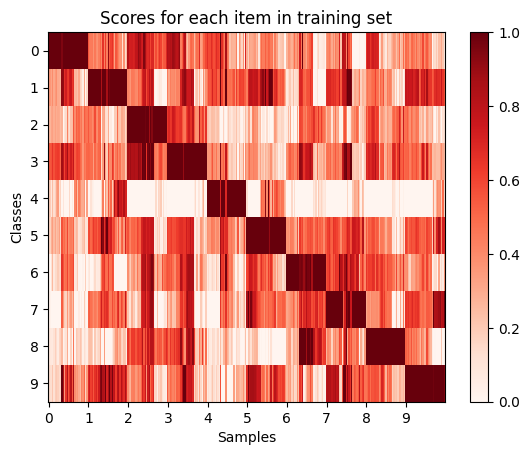

In [86]:
ticks = {}
lab = 0
for i in range(10):
    ticks[lab] = str(i)
    lab += len(data_test[i])

plt.imshow(res.T, interpolation='none', aspect='auto', cmap="Reds")
plt.xticks(ticks=list(ticks.keys()), labels=list(ticks.values()))
plt.yticks([i for i in range(10)])
plt.title("Scores for each item in training set")
plt.xlabel("Samples")
plt.ylabel("Classes")
plt.colorbar()
plt.show()

On peut voir sur le graphique ci-dessus que la diagonale est plus foncée que le reste, ce qui nous confirme que notre modèle fait de bonne prédictions.

np.float64(0.9066666666666666)

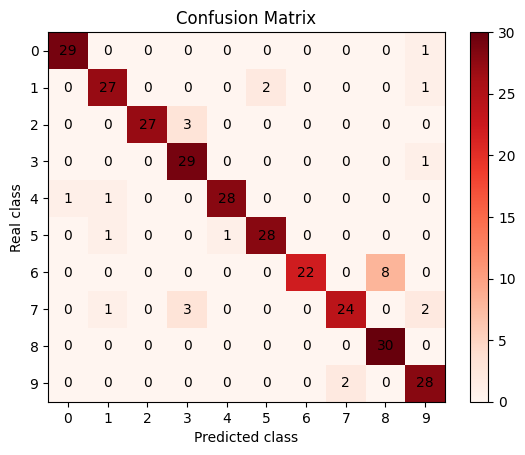

In [85]:
plt.imshow(confusion_matrix, interpolation='none', aspect='auto', cmap="Reds")
plt.xticks([i for i in range(10)])
plt.yticks([i for i in range(10)])
plt.xlabel('Predicted class')
plt.ylabel('Real class')
plt.title('Confusion Matrix')
plt.colorbar()
for (j,i),label in np.ndenumerate(confusion_matrix):
    plt.text(i,j,int(label),ha='center',va='center')

classifier.evaluate_classifier(data_test)

On obtient au final une précision de 90.7%, donc le modèle est bien plus performant que celui utilisant la méthode knn. Avec la matrice de confusion, on peut remarquer le modèle peut avoir tendance à prédire "8" dans des samples où le chiffre dit est "8" (cependant le cas inverse n'est pas vrai).